In [1]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation
from epymorph.parameter_fitting.utils import plots
from epymorph.parameter_fitting.utils.observations import Observations
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

from epymorph.parameter_fitting.dynamics.dynamics import GeometricBrownianMotion
import scipy
from epymorph.adrio import acs5, csv


In [2]:
from epymorph.data_shape import Shapes
from epymorph.initializer import Initializer
from epymorph.simulation import AttributeDef

import numpy as np


class PFInitializer(Initializer):
    requirements = [AttributeDef("population", int, Shapes.N)]

    def __init__(self, index2=0, index3=0, index4=0) -> None:
        self.index2 = index2
        self.index3 = index3
        self.index4 = index4

    def evaluate(self):
        total_population = self.data("population")[0]  # 7_174_064
        # initial_particle cloud
        initializer = np.array(
            [
                [
                    total_population - self.index2 - self.index3 - self.index4,
                    self.index2,
                    self.index3,
                    self.index4,
                ]
            ],
            dtype=np.int64,
        )
        return initializer

In [3]:
# ruff: noqa: F405
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import Sirh
from epymorph.data.mm.no import No


rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Sirh(),
    # Load an MM from the library
    mm=No(),
    # Use our scope
    scope=StateScope.in_states(["AZ"], year=2015),
    # Create a SingleLocation initializer
    # Provide an initializer of your coice or create a custom initializer as
    # above and pass it
    init=PFInitializer(50, 1434813, 23),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2022-10-01", 371),
    # Provide parameter values
    params={
        # "beta": To be estimated,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.03,
        "hospitalization_duration": 5.0,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
    },
)

In [4]:
[e.name.full for e in rume.ipm.events]

['S → I', 'I → H', 'I → R', 'H → R', 'R → S']

In [5]:
likelihood_fn = PoissonLikelihood()
filter_type = ParticleFilter(num_particles=250)

In [6]:
from pathlib import Path

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./influenza.csv"),
    time_col=0,
    time_frame=TimeFrame.range("2022-10-01", "2023-09-30"),
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [7]:
# observations = Observations(
#     InfluenzaHospitalizationSumState(rume.time_frame),
#     model_link="I → H",
# )

observations = Observations(
    csvadrio,
    model_link="I → H",
)


In [8]:
params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=scipy.stats.uniform(loc=0.1, scale=0.7),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    )
}

In [9]:
sim = FilterSimulation(
    rume=rume,
    observations=observations,
    likelihood_fn=likelihood_fn,
    filter_type=filter_type,
    params_space=params_space,
)

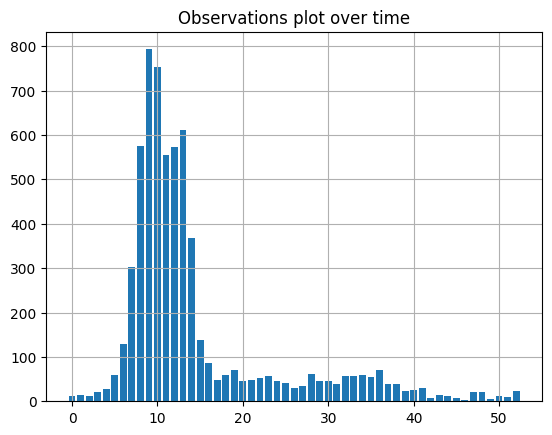

In [10]:
sim.plot_data()

In [11]:
output = sim.run()

100%|██████████| 53/53 [00:49<00:00,  1.07it/s]


In [12]:
output

ParticleFilterOutput(num_particles=250, duration='371 days ', param_quantiles={'beta': [array([[0.11280079],
       [0.12378036],
       [0.13820551],
       [0.15291258],
       [0.17362269],
       [0.21586504],
       [0.24585625],
       [0.2907889 ],
       [0.34790689],
       [0.37934785],
       [0.42404447],
       [0.46532669],
       [0.49979386],
       [0.51259295],
       [0.54900471],
       [0.58670338],
       [0.60808624],
       [0.67859106],
       [0.69379161],
       [0.72852438],
       [0.76539762],
       [0.78571594],
       [0.78982989]]), array([[0.37059375],
       [0.39516826],
       [0.44096002],
       [0.44428857],
       [0.48360157],
       [0.52078374],
       [0.60826474],
       [0.65360572],
       [0.65699906],
       [0.67381427],
       [0.67433081],
       [0.69752886],
       [0.72436832],
       [0.73789854],
       [0.74401316],
       [0.74568184],
       [0.762639  ],
       [0.8806475 ],
       [0.90333183],
       [0.90333183],
       

In [13]:
# print(output)

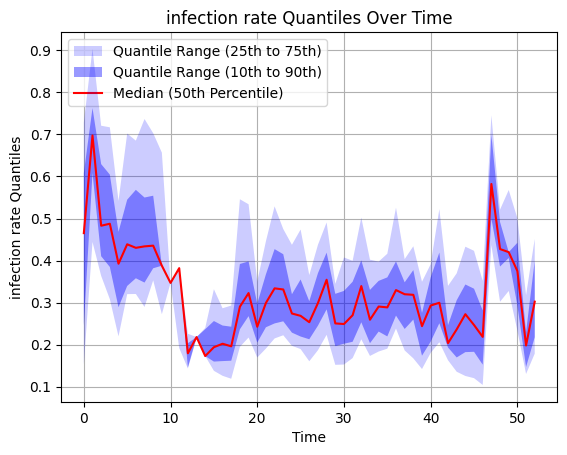

In [16]:
plots.params_plot(output=output, parameter="infection rate")

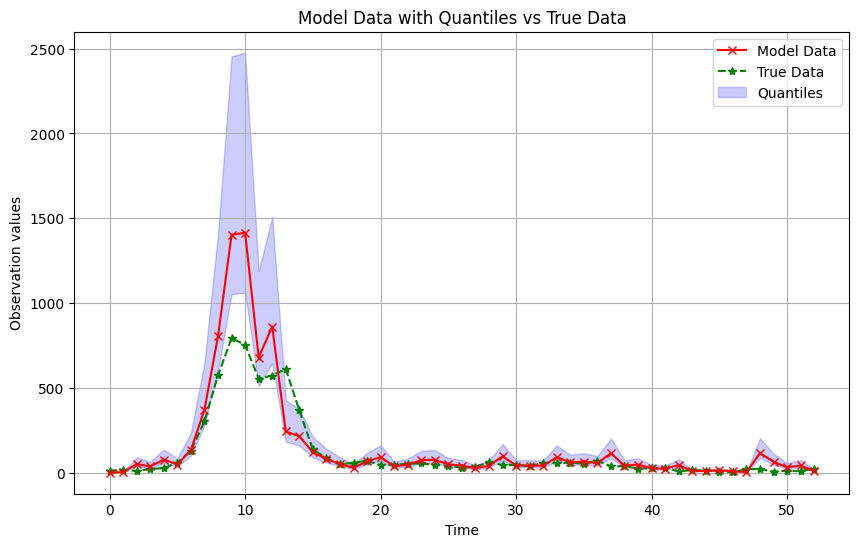

In [17]:
plots.model_fit(output=output)